# Hodographs

## Setup

In [8]:
# Import statements
import xarray as xr
import matplotlib.pyplot as plt
from typing import List
import cartopy.crs as ccrs
from metpy.plots import Hodograph
from metpy.units import units
import numpy as np

plt.style.use("dark_background")


In [2]:
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def overwrite_ne(da: xr.DataArray | xr.Dataset) -> xr.DataArray | xr.Dataset:
    """Overwrite 'ne' values in the DataArray or Dataset."""
    da["ne"] = range(5)
    return da


def stack_and_chunk(data_arrays, dim_name, chunk_size):
    """Concatenate, stack, and chunk the given data arrays."""
    return (
        xr.concat(data_arrays, dim=dim_name)
        .stack(run=(dim_name, "ne"))
        .chunk({"run": chunk_size})
    )


def process_variable(
    wofs_list: List[xr.Dataset], var_name: str, overwrite: bool = False
) -> xr.DataArray:
    """Process a variable data with optional 'ne' overwrite."""
    data_arrays = [
        overwrite_ne(getattr(ds, var_name)) if overwrite else getattr(ds, var_name)
        for ds in wofs_list
    ]
    return stack_and_chunk(data_arrays, "init", "auto" if overwrite else -1)


In [83]:
# Read in just 20Z initializations
wofs_all = get_wofs_all(22)

In [36]:
# Define variables and parameters
lat = wofs_all.xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all.xlon.isel(time=0).squeeze().drop_vars("time")

lat_coarse = (
    wofs_all.xlat_snd.isel(time=0)
    .squeeze()
    .drop_vars("time")
    .rename(dict(dim_0="ny", dim_1="nx"))
)
lon_coarse = (
    wofs_all.xlon_snd.isel(time=0)
    .squeeze()
    .drop_vars("time")
    .rename(dict(dim_0="ny", dim_1="nx"))
)

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all.attrs["CEN_LON"],
    central_latitude=wofs_all.attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Create a DataArray for the initialization dimension
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
)


In [5]:
# Some useful functions
def get_mean_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the mean of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Mean variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).mean(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


def get_total_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the sum of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).sum(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


## Testing with one gridbox and time

In [6]:
u = wofs_all.u.isel(time=60, ne=0, nx=9, ny=9).load() * units("m/s")
v = wofs_all.v.isel(time=60, ne=0, nx=9, ny=9).load() * units("m/s")
p = wofs_all.p.isel(time=60, ne=0, nx=9, ny=9).load() * units("hPa")
z = wofs_all.z_agl.isel(time=60, ne=0, nx=9, ny=9).load() * units("m")


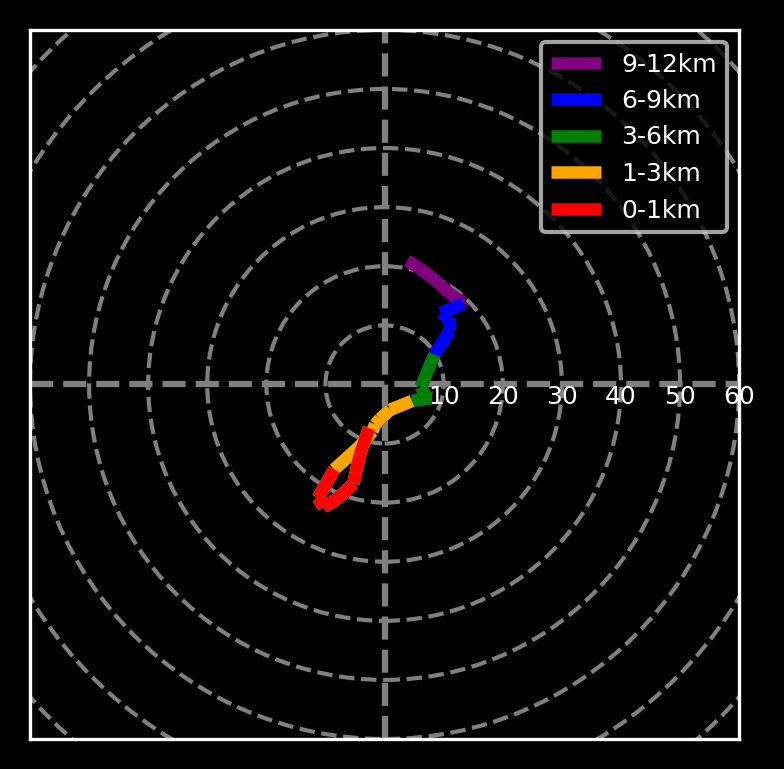

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), dpi=300, layout="constrained")

# Define height ranges in meters and corresponding colors
height_ranges = [
    (9000, 12000, "purple", "9-12km"),
    (6000, 9000, "blue", "6-9km"),
    (3000, 6000, "green", "3-6km"),
    (1000, 3000, "orange", "1-3km"),
    (0, 1000, "red", "0-1km"),
]

hodograph = Hodograph(ax, component_range=60)
hodograph.add_grid(increment=10)


# Plot the entire hodograph starting from the highest altitude range down to the lowest
for z_min, z_max, color, label in height_ranges:
    mask = z.values < z_max
    hodograph.plot_colormapped(u[mask], v[mask], z[mask], color=color, label=label)

# Add circle labels at 10, 20, 30, 40, 50, 60
circle_labels = np.arange(10, 70, 10)
for label in circle_labels:
    ax.text(label, 0, str(label), fontsize=6, ha="center", va="top")
# Remove the axis labels and ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

plt.legend(fontsize=6, loc="upper right")
plt.show()


## Get a wet and dry member

In [80]:
# Set desired latitude and longitude (Central Park)
nyc_lat, nyc_lon = 40.7826, -73.9656

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat - nyc_lat) ** 2 + (lon - nyc_lon) ** 2)
nyc_inds = distance.argmin(dim=["NY", "NX"])
lat_ind, lon_ind = int(nyc_inds["NY"]), int(nyc_inds["NX"])

# Calculate the 1-2 UTC rainfall
rain12 = wofs_all.rain.sel(
    time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00")
).sum(dim="time")

# Extract the rainfall value in NYC
rain12_nyc = rain12.isel(lat=lat_ind, lon=lon_ind)


In [84]:
# Take a look at the rainiest and driest members
rain12_nyc.ne.sortby(rain12_nyc).load()

<xarray.DataArray 'ne' (ne: 18)> Size: 144B
array([13,  0,  5, 12, 16,  9, 11, 15,  3,  8,  2,  6,  7, 10, 17, 14,  4,  1])
Dimensions without coordinates: ne

## Compare wettest and driest ensemble members

In [85]:
# First, find the nx and ny closest to, say, Morristown
mor_lat, mor_lon = 40.7968, -74.4815

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat_coarse - mor_lat) ** 2 + (lon_coarse - mor_lon) ** 2)
mor_inds = distance.argmin(dim=["ny", "nx"])
lat_ind, lon_ind = int(mor_inds["ny"]), int(mor_inds["nx"])


In [90]:
def extract_data(var, ne_index):
    return wofs_all[var].sel(time="2021-09-02 00:00:00").isel(
        ne=ne_index, ny=lat_ind, nx=lon_ind
    ).squeeze().load() * units("m/s" if var in ["u", "v"] else "m")


u_wet = extract_data("u", 1)
v_wet = extract_data("v", 1)
z_wet = extract_data("z_agl", 1)

u_dry = extract_data("u", 13)
v_dry = extract_data("v", 13)
z_dry = extract_data("z_agl", 13)


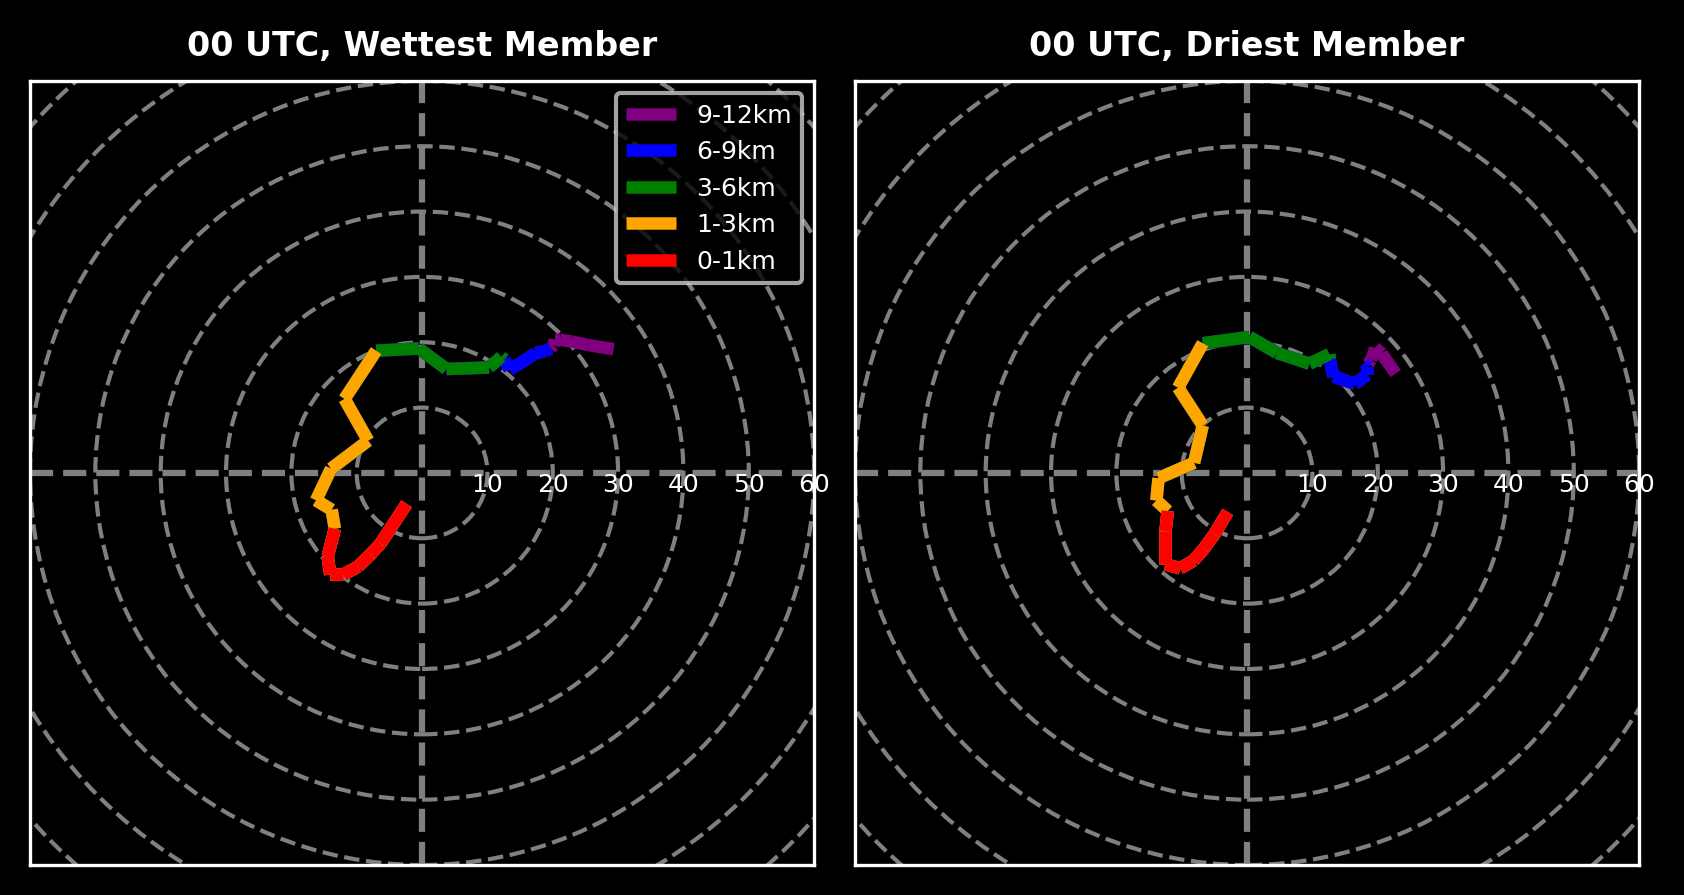

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(5.5, 3), dpi=300, layout="constrained")

us = [u_wet, u_dry]
vs = [v_wet, v_dry]
zs = [z_wet, z_dry]
titles = ["00 UTC, Wettest Member", "00 UTC, Driest Member"]

# Define height ranges in meters and corresponding colors
height_ranges = [
    (9000, 12000, "purple", "9-12km"),
    (6000, 9000, "blue", "6-9km"),
    (3000, 6000, "green", "3-6km"),
    (1000, 3000, "orange", "1-3km"),
    (0, 1000, "red", "0-1km"),
]

for i, ax in enumerate(axes.flatten()):  # type: ignore
    hodograph = Hodograph(ax, component_range=60)
    hodograph.add_grid(increment=10)

    # Plot the entire hodograph starting from the highest altitude range down to the lowest
    for z_min, z_max, color, label in height_ranges:
        mask = z.values < z_max
        hodograph.plot_colormapped(
            us[i][mask], vs[i][mask], zs[i][mask], color=color, label=label
        )

    # Add circle labels at 10, 20, 30, 40, 50, 60
    circle_labels = np.arange(10, 70, 10)
    for label in circle_labels:
        ax.text(label, 0, str(label), fontsize=6, ha="center", va="top")
    # Remove the axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.set_title(titles[i], fontsize=8, fontweight="bold")

axes[0].legend(fontsize=6, loc="upper right")  # type: ignore
plt.show()
